# Constrained Online Meta-Learning
## B: Online Meta Learning

## We analyse the MAML algorithm for the batch mode in order to assess its convergence

# $\theta_m = \theta-\nabla f_m(\theta)$

# $-\Sigma_{n=1}^N[ y_{mn} ln\hat{y_{\theta}} + (1-y_{mn})ln(1-\hat{y_{\theta}})]\frac{1}{N}$

## Loss = - $\Sigma_{m=1}^M \Sigma_{n=1}^N[ y_{mn} ln\hat{y_{\theta_mn}} + (1-y_{mn})ln(1-\hat{y_{\theta_mn}})]\frac{1}{NM}$


## $ \frac{d\theta_i}{d\theta} = \frac{d(\theta+\eta_1[1/N(\Sigma_{x,y \sim T_i}(y(1-y_\theta)-(1-y)y_\theta))])}{d\theta} = 1-\eta_1\frac{\Sigma_{x,y \sim T_i} y_{\theta} (1-y_\theta)}{N}$

## $\frac{d Loss}{d\theta} = - \frac{1}{M}\Sigma_{m=1}^M \frac{1}{N_{T_m} }\Sigma_{x,y \sim T_m} [(1-\eta_1 \Sigma_{x,y \sim T_{m_{tune}}} \frac{y_\theta}{N(1-y_\theta)})(y-y_{\theta'})]$

## Update : $\theta \rightarrow \theta+\eta_2 \frac{1}{M}\Sigma_{m=1}^M \frac{1}{N_{T_m} }\Sigma_{x,y \sim T_m} [(1-\eta_1 \Sigma_{x,y \sim T_{m_{tune}}} \frac{y_\theta}{N(1-y_\theta)})(y-y_{\theta_mn})]$

In [11]:
import numpy as np
import matplotlib.pyplot as plt 
def random_walk():
    a = np.random.randint(0,2, size = (25))
    a = np.cumsum(2*a-1)
    return(a)



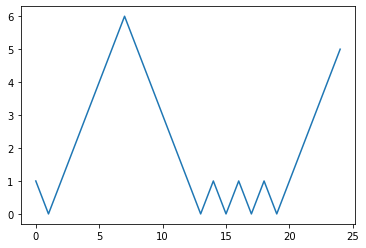

In [12]:
mean_a = random_walk()
plt.plot(-mean_a)

### Meta training Be The Leader

![FTML1.png](./FTML1.png)

In [13]:
step_size = 0.5

step_size_fine = step_size*10

X = []

btl_param = [0]
ftl_param = [0]
btl_loss = []
ftl_loss = []
btl_fine_param = []
ftl_fine_param = []

#The i tasks::

for (i,mean) in enumerate(mean_a):
    x_curr = np.random.randn(100)
    x_curr = x_curr + mean
    X.append(x_curr)    
    loss_grad_btl = 0
    loss_grad_ftl = 0

    theta_btl = btl_param[i]
    theta_ftl = ftl_param[i]
    ### The Meta Training on i tasks ::
    
    for j in range(200):

#         loss_grad_ftl = 0
        loss_grad_btl = 0
        for k,x in enumerate(X):
            # I) 1-step fine tuning for task k

            # a) Tune data points, x_tune of task m
            x_tune = np.random.randn(100)+mean_a[k]
            ind_tune_1 = x_tune > mean_a[k]
            ind_tune_0 = x_tune < mean_a[k]
            
            # b) Gradient of loss of task m at theta
            loss_fine_grad = (-np.sum((1-1/(1+np.exp(-(x_tune[ind_tune_1]+theta_btl)))))+np.sum(1/(1+np.exp(-(x_tune[ind_tune_0]+theta_btl)))))
            loss_fine_grad/=len(x_tune)
            
            loss_fine_grad_ftl = (-np.sum((1-1/(1+np.exp(-(x_tune[ind_tune_1]+theta_ftl)))))+np.sum(1/(1+np.exp(-(x_tune[ind_tune_0]+theta_ftl)))))
            loss_fine_grad_ftl/=len(x_tune)
            
            # c) Fine tune update
            theta_btl_fine = theta_btl-step_size_fine*(loss_fine_grad)
            theta_ftl_fine = theta_ftl-step_size_fine*(loss_fine_grad_ftl)

            # II) Meta update on the parameter
            
            # a)Theta and Theta_fine predictions on x
            y_fine = 1/(1+np.exp(-(x+theta_btl_fine)))
            y_theta  = 1/(1+np.exp(-(x+theta_btl)))

            ind_1 = x > mean_a[k]
            ind_0 = x < mean_a[k]
            # b) True labels for x 
            y = np.array(ind_1 ,dtype = 'float')
            # c) META UPDATE
            loss_grad_btl += -1/(len(X))*(1/len(x))*(1-step_size_fine*np.sum(y_theta*(1-y_theta))/len(x_tune))*np.sum(y-y_fine)
            
            y_fine = 1/(1+np.exp(-(x+theta_ftl_fine)))
            y_theta  = 1/(1+np.exp(-(x+theta_ftl)))
            
            loss_grad_ftl += -1/(len(X))*(1/len(x))*(1-step_size_fine*np.sum(y_theta*(1-y_theta))/len(x_tune))*np.sum(y-y_fine)
        loss_grad_ftl -= -1/(len(X))*(1/len(x))*(1-step_size_fine*np.sum(y_theta*(1-y_theta))/len(x_tune))*np.sum(y-y_fine)

        theta_btl = theta_btl - step_size*(loss_grad_btl)
        theta_ftl = theta_ftl - step_size*(loss_grad_ftl)
        
    btl_param.append(theta_btl)        
    ftl_param.append(theta_ftl)
    ind_1 = x_curr > mean
    ind_0 = x_curr < mean 
    loss_fine = (np.sum(np.log(1+np.exp(-(x_curr[ind_1]+theta_btl))))-np.sum(np.log(np.exp(-(x_curr[ind_0]+theta_btl))/(1+np.exp(-(x_curr[ind_0]+theta_btl))))))/len(x_curr)  
    # III) Fine tune for current task                                     
    loss_fine_grad = (-np.sum((1-1/(1+np.exp(-(x_tune[ind_tune_1]+theta_btl)))))+np.sum(1/(1+np.exp(-(x_tune[ind_tune_0]+theta_btl)))))/len(x_tune)
    btl_param_fine = theta_btl-step_size_fine*(loss_fine_grad)
    btl_fine_param.append(theta_btl_fine)
    
    loss_fine_grad = (-np.sum((1-1/(1+np.exp(-(x_tune[ind_tune_1]+theta_ftl)))))+np.sum(1/(1+np.exp(-(x_tune[ind_tune_0]+theta_ftl)))))/len(x_tune)
    theta_ftl_fine = theta_ftl-step_size_fine*(loss_fine_grad)
    ftl_fine_param.append(theta_ftl_fine)
    
    btl_curr_loss = (np.sum(np.log(1+np.exp(-(x_curr[ind_1]+theta_btl_fine))))-np.sum(np.log(np.exp(-(x_curr[ind_0]+theta_btl_fine))/(1+np.exp(-(x_curr[ind_0]+theta_btl_fine))))))/len(x_curr)  
    ftl_curr_loss = (np.sum(np.log(1+np.exp(-(x_curr[ind_1]+theta_ftl_fine))))-np.sum(np.log(np.exp(-(x_curr[ind_0]+theta_ftl_fine))/(1+np.exp(-(x_curr[ind_0]+theta_ftl_fine))))))/len(x_curr)  
    

    btl_loss.append(btl_curr_loss)
    ftl_loss.append(ftl_curr_loss)



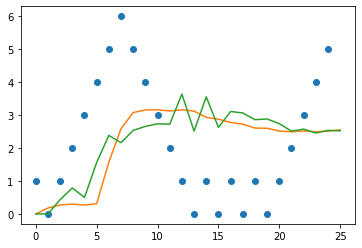

In [14]:
plt.plot(-mean_a,'o')
plt.plot(btl_param)
plt.plot(ftl_param)


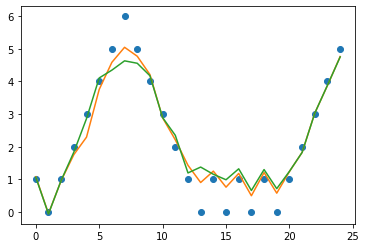

In [15]:
plt.plot(-

### The comparator, ftl and btl performance 

In [16]:
comparator_param = btl_param[-1]
loss_comp = []
comparator_fine_param = []
for k,x in enumerate(X):
    
    x_tune = np.random.randn(100)+mean_a[k]
    ind_tune_1 = x_tune > mean_a[k]
    ind_tune_0 = x_tune < mean_a[k]
    # Gradient of loss of task m at theta
    loss_fine_grad = (-np.sum((1-1/(1+np.exp(-(x_tune[ind_tune_1]+comparator_param)))))+np.sum(1/(1+np.exp(-(x_tune[ind_tune_0]+comparator_param)))))
    loss_fine_grad/=len(x_tune)
    # Comparotor fine update
    comparator_param_fine = comparator_param -step_size_fine*loss_fine_grad
    comparator_fine_param.append(comparator_param_fine)
    ind_1 = x > mean_a[k]
    ind_0 = x < mean_a[k]    
    loss_comp.append((np.sum(np.log(1+np.exp(-(x[ind_1]+comparator_param_fine))))-np.sum(np.log(np.exp(-(x[ind_0]+comparator_param_fine))/(1+np.exp(-(x[ind_0]+comparator_param_fine))))))/len(x))
# plt.plot(np.cumsum(ftl_loss)[1:])
# plt.plot(np.cumsum(btl_loss)[1:])
# plt.plot(np.cumsum(np.array(loss_comp)))
# plt.plot(comparator_fine_param)

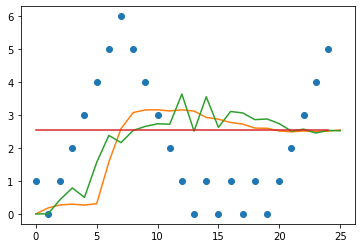

In [17]:
plt.plot(-mean_a,'o')
plt.plot(btl_param)
plt.plot(ftl_param)
plt.plot(np.ones(25)*comparator_param)

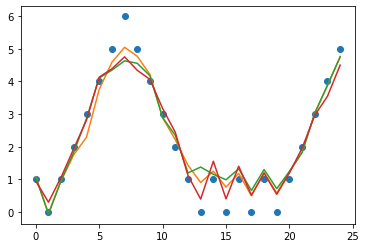

In [18]:
plt.plot(-mean_a,'o')
plt.plot(btl_fine_param)
plt.plot(ftl_fine_param)
plt.plot(comparator_fine_param)

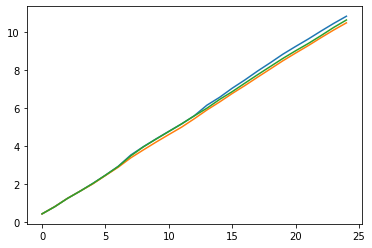

In [19]:
plt.plot(np.cumsum(ftl_loss))
plt.plot(np.cumsum(btl_loss))
plt.plot(np.cumsum(loss_comp))

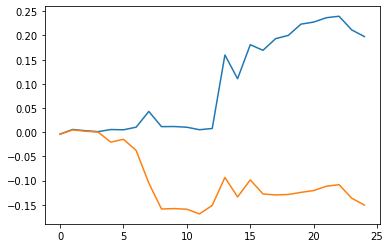

In [20]:
plt.plot(np.cumsum(ftl_loss)-np.cumsum(loss_comp))
plt.plot(np.cumsum(btl_loss)-np.cumsum(loss_comp))


### FTML largely ends the discussion on adverserial Meta Learning with adverserially chosen tasks as opposed to adverserial samples

### Constraining the adversary and using FTML for adverserial meta learning tasks (complex sim/ real) are the directions of work that may lead to exciting and novel contributions

# Proposed constrained adversarial meta learning solution

$L_t = \Sigma_{r=1}^{t-1} f_r(U_r(w_t)) + \Sigma_{r=1}^T (\lambda (|U_r(w_t)-U_{r-1}(w_t)| -r\delta)) $

$w^* = argmin (L_t(w))$